In [ ]:
!pip install pyspark

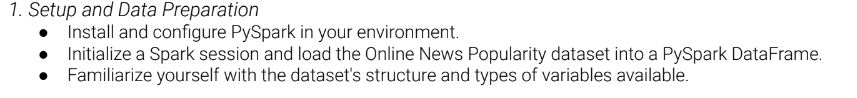

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
            .appName("Online News Popularity") \
            .getOrCreate()

In [ ]:
data = spark.read.csv("OnlineNewsPopularity.csv", header=True, inferSchema=True)

In [ ]:
data.show(5)

+--------------------+----------+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+-

In [ ]:
data.describe().show()

+-------+--------------------+------------------+------------------+------------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+--------------------+--------------------------+---------------------------

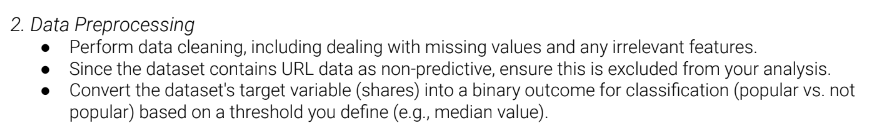

In [ ]:
data = data.drop("url")
data = data.dropna()
data.show()

+----------+---------------+-----------------+----------------+-----------------+-------------------------+----------+---------------+---------+-----------+---------------------+-------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+---------------------------+------------------+-------------------+---------------------+--------------------+------------------+--------------------+------------------+-----------+---------------+---------------+---------------+---------------+---------------+--------------------+--------------------------+---------------------------+---------------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------

In [ ]:
data.printSchema()

root
 |--  timedelta: double (nullable = true)
 |--  n_tokens_title: double (nullable = true)
 |--  n_tokens_content: double (nullable = true)
 |--  n_unique_tokens: double (nullable = true)
 |--  n_non_stop_words: double (nullable = true)
 |--  n_non_stop_unique_tokens: double (nullable = true)
 |--  num_hrefs: double (nullable = true)
 |--  num_self_hrefs: double (nullable = true)
 |--  num_imgs: double (nullable = true)
 |--  num_videos: double (nullable = true)
 |--  average_token_length: double (nullable = true)
 |--  num_keywords: double (nullable = true)
 |--  data_channel_is_lifestyle: double (nullable = true)
 |--  data_channel_is_entertainment: double (nullable = true)
 |--  data_channel_is_bus: double (nullable = true)
 |--  data_channel_is_socmed: double (nullable = true)
 |--  data_channel_is_tech: double (nullable = true)
 |--  data_channel_is_world: double (nullable = true)
 |--  kw_min_min: double (nullable = true)
 |--  kw_max_min: double (nullable = true)
 |--  kw_avg

In [ ]:
median_shares = data.approxQuantile(" shares", [0.5], 0.01)[0]
data = data.withColumn("popularity", (data[" shares"] >= median_shares).cast("integer"))

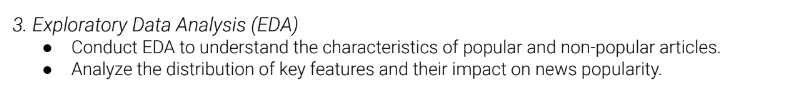

In [ ]:
data.groupBy("popularity").count().show()
data.describe().show()

+----------+-----+
|popularity|count|
+----------+-----+
|         1|21154|
|         0|18490|
+----------+-----+

+-------+------------------+------------------+------------------+------------------+-----------------+-------------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------------+------------------------------+--------------------+-----------------------+---------------------+----------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------------+--------------------------+---------------------------+-------------------+-------------------+---------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-

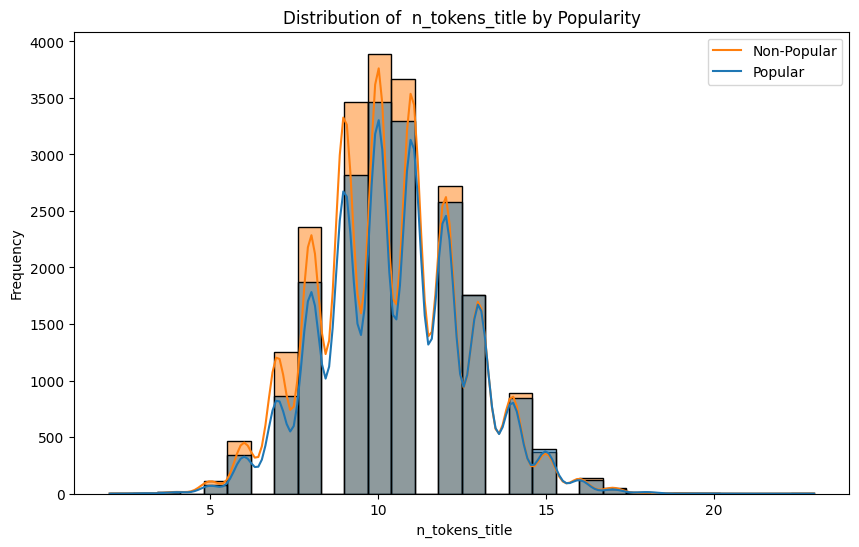

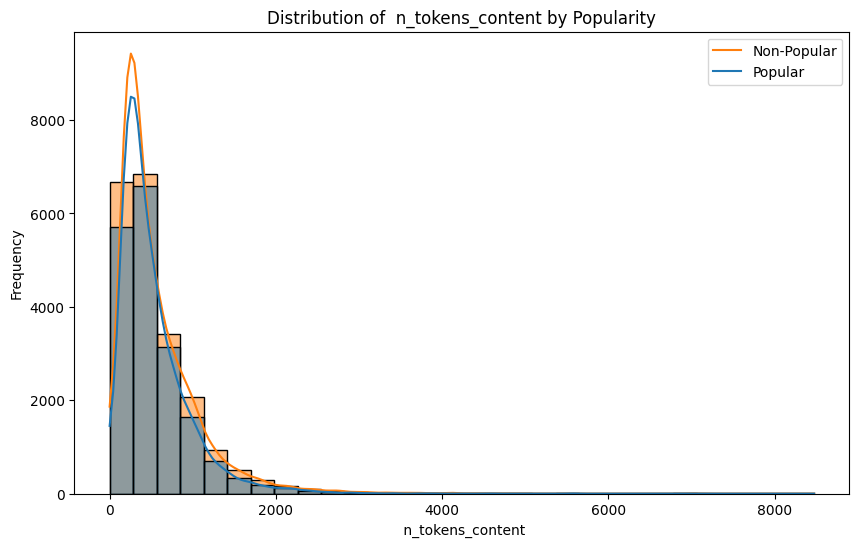

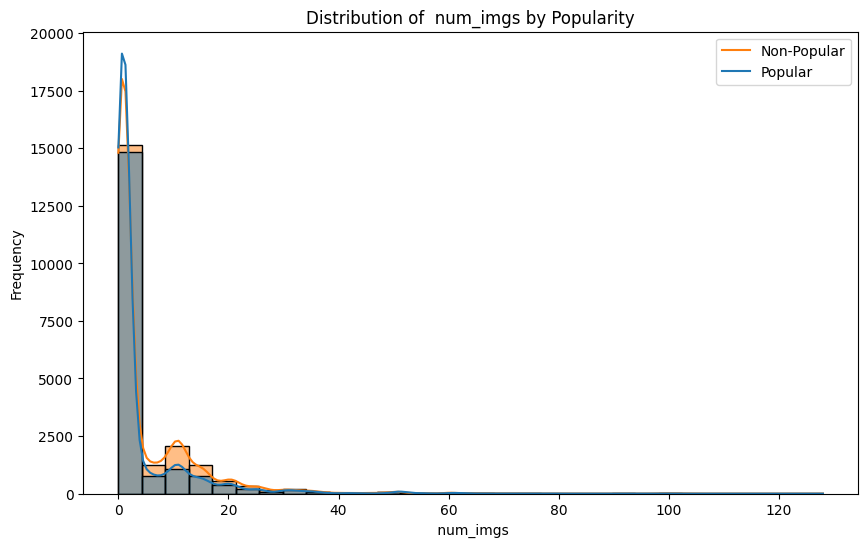

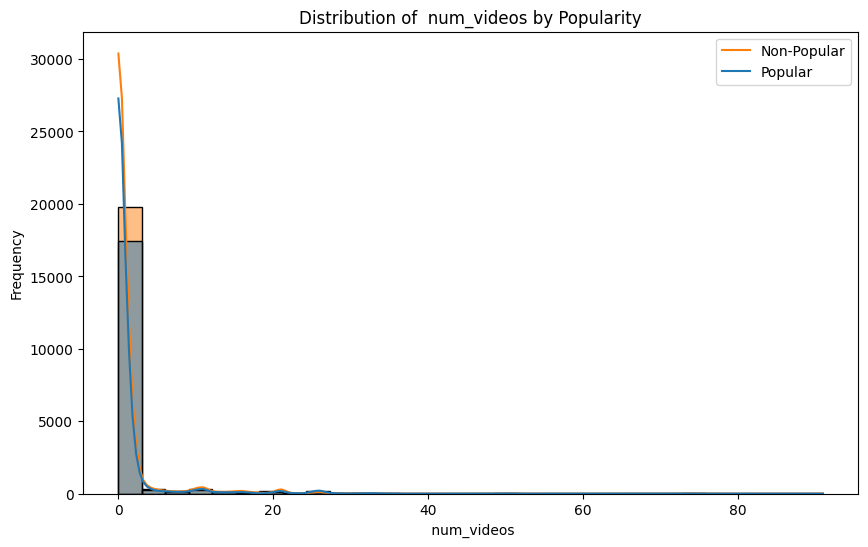

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Relationship between shares and other numerical features
numeric_features = [" n_tokens_title", " n_tokens_content", " num_imgs", " num_videos"]

for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data.toPandas(), x=feature, hue="popularity", kde=True, bins=30, alpha=0.5)
    plt.title(f"Distribution of {feature} by Popularity")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend(["Non-Popular", "Popular"])
    plt.show()


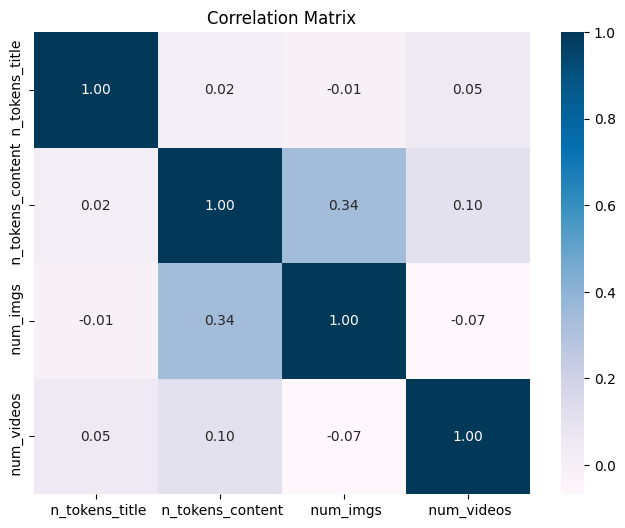

In [ ]:
numeric_data = data.select(numeric_features)
correlation_matrix = numeric_data.toPandas().corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="PuBu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

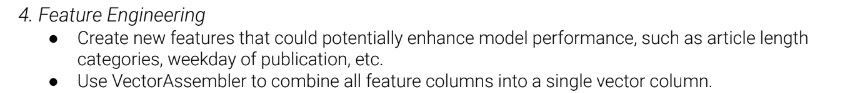

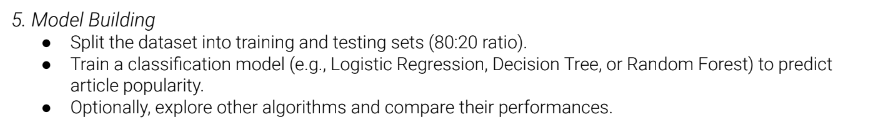

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np

# Define the feature vector
feature_cols = [col for col in data.columns if col not in ["shares", "popularity"]]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Split dataset into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="popularity")
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)


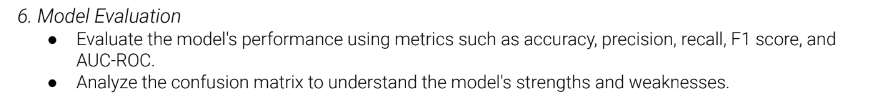

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="popularity", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Analyze the confusion matrix
conf_matrix = predictions.groupBy("popularity", "prediction").count()
conf_matrix.show()

Accuracy: 0.6440894568690095
+----------+----------+-----+
|popularity|prediction|count|
+----------+----------+-----+
|       1.0|       1.0| 3155|
|       0.0|       1.0| 1791|
|       1.0|       0.0|  994|
|       0.0|       0.0| 1885|
+----------+----------+-----+



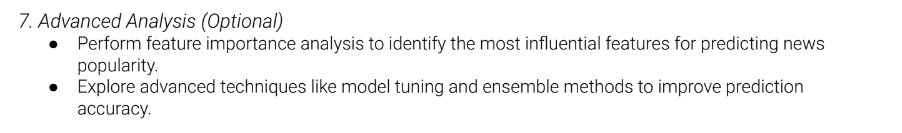

In [ ]:
from tabulate import tabulate

importances = model.stages[-1].featureImportances.toArray()
feature_importance = [(feature_cols[i], importances[i]) for i in range(len(feature_cols))]

# Sort features based on their importances
feature_importance.sort(key=lambda x: x[1], reverse=True)

print("Feature Importance:")
print(tabulate(feature_importance, headers=["Feature", "Importance"], tablefmt="pretty"))


Feature Importance:
+-------------------------------+------------------------+
|            Feature            |       Importance       |
+-------------------------------+------------------------+
|          kw_avg_avg           |  0.16081178392475604   |
|          kw_max_avg           |   0.1365706730836735   |
|  self_reference_avg_sharess   |  0.07732935932470406   |
|   self_reference_max_shares   |   0.0722693174017497   |
|          kw_min_avg           |  0.055629983161958566  |
| data_channel_is_entertainment |  0.05424424096677418   |
|          is_weekend           |  0.043358392743774954  |
|     data_channel_is_tech      |  0.041149499245890675  |
|     data_channel_is_world     |  0.03994199374042675   |
|            LDA_02             |  0.03909295924438773   |
|      weekday_publication      |  0.028550166331238948  |
|           timedelta           |  0.025802656970375388  |
|            LDA_04             |  0.025011071930305755  |
|   self_reference_min_shares   |  0

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="popularity")
pipeline_rf = Pipeline(stages=[assembler, rf])
model_rf = pipeline_rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)
accuracy_rf = evaluator.evaluate(predictions_rf)
print("Random Forest Accuracy:", accuracy_rf)

Random Forest Accuracy: 0.6440894568690095
